In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hull-tactical-market-prediction/train.csv
/kaggle/input/hull-tactical-market-prediction/test.csv
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_inference_server.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2_grpc.py
/kaggl

INFO:root:Running local gateway for testing.
ERROR:root:Local gateway simulation failed. This is expected outside Kaggle: (<GatewayRuntimeErrorType.GATEWAY_RAISED_EXCEPTION: 5>, 'Traceback (most recent call last):\n  File "/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py", line 132, in run\n    predictions, row_ids = self.get_all_predictions()\n                           ^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/core/base_gateway.py", line 107, in get_all_predictions\n    for data_batch, row_ids in self.generate_data_batches():\n  File "/kaggle/input/hull-tactical-market-prediction/kaggle_evaluation/default_gateway.py", line 27, in generate_data_batches\n    test = pl.read_csv(self.competition_data_dir / \'test.csv\')\n           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^\n  File "/usr/local/lib/python3.11/dist-packages/polars/_utils/deprecation.py", line 114, in wrapper\n    return f

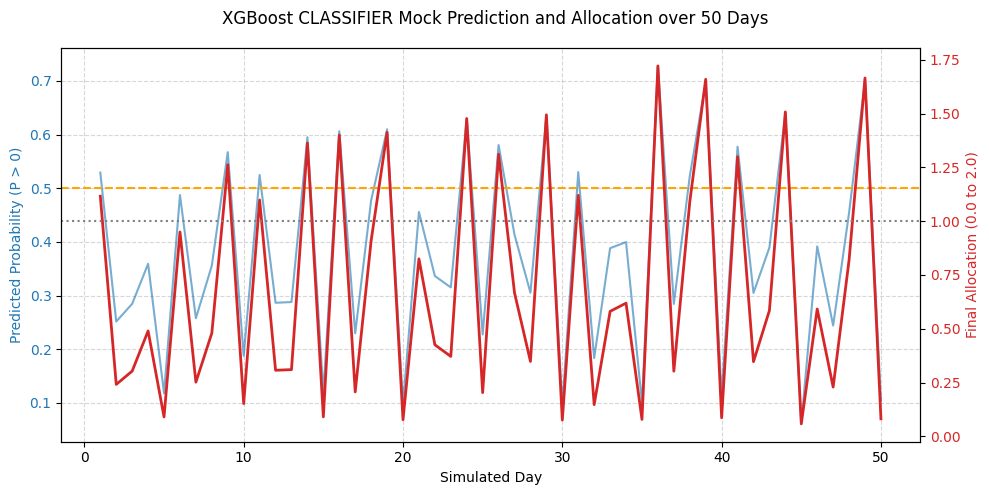

INFO:root:Generating dummy submission.parquet for Kaggle system check.
INFO:root:submission.parquet created successfully.


In [2]:
import os
import polars as pl
import numpy as np
import logging
from typing import Dict, Any, List
import pandas as pd 
import matplotlib.pyplot as plt
import xgboost as xgb 

# --- Kaggle Evaluation API Interface (Mandatory) ---
try:
    import kaggle_evaluation.default_inference_server as inference_server
except ImportError:
    # Mock definitions for local testing environment
    class MockInferenceServer:
        def __init__(self, predict_fn):
            self.predict_fn = predict_fn
        def serve(self):
            logging.info("Mock Inference Server Running...")
        def run_local_gateway(self, path):
            logging.info(f"Mock Local Gateway Running with path: {path}")
    inference_server = MockInferenceServer

# --- Global Model Variables ---
MODEL = None
TRAIN_COLS = None
TRAIN_MEANS = None 

logging.basicConfig(level=logging.INFO)

# --- Feature Engineering and Selection ---

def get_features(df: pl.DataFrame) -> List[str]:
    """Dynamically identifies base feature columns (M*, E*, V*, S*, etc.)."""
    EXCLUDE_COLS = ['date_id', 'forward_returns', 'risk_free_rate', 
                    'market_forward_excess_returns', 'is_scored', 
                    'lagged_forward_returns', 'lagged_risk_free_rate', 
                    'lagged_market_forward_excess_returns']
    
    feature_cols = [col for col in df.columns if col not in EXCLUDE_COLS]
    return feature_cols

def preprocess_data(df: pl.DataFrame, is_training: bool = False) -> pd.DataFrame:
    """
    Standard preprocessing for the financial time series data, including
    the creation of interaction features, EMAs, rolling means/stdevs, and lags.
    """
    
    # --- Polars Feature Engineering (Time Series Features) ---
    
    if 'date_id' in df.columns:
        df = df.with_columns(
            (pl.col('date_id') % 5).alias('day_of_cycle') # Proxy for Day-of-Week
        )
    
    ROLLING_WINDOWS = [5, 10, 20] 
    BASE_FEATURES = ['M1', 'E1', 'V1', 'S1', 'T1', 'P1', 'D1']

    expressions = []
    
    # --- OPTIMIZATION 1: Simple Lag Features for Momentum ---
    LAG_WINDOWS = [1, 5]
    for lag in LAG_WINDOWS:
        for col in BASE_FEATURES:
            if col in df.columns:
                expressions.append(
                    pl.col(col).shift(lag).alias(f'{col}_lag_{lag}')
                )
    
    # --- Rolling Mean and Std Dev Features (Momentum and Volatility) ---
    for window in ROLLING_WINDOWS:
        for col in BASE_FEATURES:
            if col in df.columns:
                # Rolling Mean (Trend) - Using min_samples for Polars deprecation
                expressions.append(
                    pl.col(col).rolling_mean(window_size=window, min_samples=1).alias(f'{col}_roll_mean_{window}')
                )
                # Rolling Standard Deviation (Volatility/Risk) - Using min_samples
                expressions.append(
                    pl.col(col).rolling_std(window_size=window, min_samples=1).alias(f'{col}_roll_std_{window}')
                )
    
    if expressions:
        df = df.with_columns(expressions)
        
    # --- Convert to Pandas and create Interaction and EMA Features ---
    pdf = df.to_pandas()
    
    # 4. Exponential Moving Averages (EMAs - Better for Financial Momentum)
    EMA_WINDOWS = [10, 30, 60] 
    for window in EMA_WINDOWS:
        for col in BASE_FEATURES:
            if col in pdf.columns:
                # Use Pandas' ewm (Exponentially Weighted Moving) for EMA calculation
                pdf[f'{col}_ema_{window}'] = pdf[col].ewm(span=window, adjust=False).mean()
    
    # 5. Interaction Features (Ratios and Differences)
    FEATURE_PAIRS = [('M1', 'M2'), ('E1', 'E2'), ('V1', 'V2'), 
                     ('S1', 'S2'), ('T1', 'T2'), ('P1', 'P2'), ('D1', 'D2')]

    for col1, col2 in FEATURE_PAIRS:
        if col1 in pdf.columns and col2 in pdf.columns:
            # Create Ratio Feature: Avoid division by zero by adding a small epsilon
            pdf[f'{col1}_div_{col2}'] = pdf[col1] / (pdf[col2].replace(0, 1e-6) + 1e-6)
            # Create Difference Feature
            pdf[f'{col1}_minus_{col2}'] = pdf[col1] - pdf[col2]
        
    # Drop non-feature columns that are not needed for the ML pipeline
    EXCLUDE_FINAL_COLS = ['date_id', 'forward_returns', 'risk_free_rate', 
                          'market_forward_excess_returns', 'is_scored', 
                          'lagged_forward_returns', 'lagged_risk_free_rate', 
                          'lagged_market_forward_excess_returns']
                          
    final_cols = [col for col in pdf.columns if col not in EXCLUDE_FINAL_COLS]
    
    return pdf[final_cols]

# --- Core Prediction and Allocation Logic ---

def train_model(train_df: pl.DataFrame):
    """
    Trains an XGBoost Classifier to predict the SIGN of the excess return.
    """
    global MODEL, TRAIN_COLS, TRAIN_MEANS 
    
    # Target is binary: Predict 1 if the return is positive, 0 otherwise.
    y_train = (train_df['market_forward_excess_returns'].to_numpy() > 0).astype(int)
    
    # Prepare Features
    X_train_pd = preprocess_data(train_df, is_training=True)
    
    # Update TRAIN_COLS to the full list of features
    TRAIN_COLS = list(X_train_pd.columns) 
    
    # Impute Data Manually
    TRAIN_MEANS = X_train_pd.mean()
    X_train_pd = X_train_pd.fillna(TRAIN_MEANS)
    
    # Define and fit the model directly
    regressor = xgb.XGBClassifier( # CLASSIFIER
        objective='binary:logistic',
        n_estimators=1200,             # High n_estimators to maximize model capacity
        # UPDATED: Increased learning rate (eta) from 0.03 to 0.08. 
        # CAUTION: This increases training speed but also significantly raises the risk of overfitting.
        learning_rate=0.08,           
        max_depth=8,                   # Increased depth
        subsample=0.8,                
        colsample_bytree=0.8,         
        random_state=42, 
        n_jobs=4, 
        # --- OPTIMIZATION 2: Stronger Regularization to Prevent Overfitting ---
        reg_lambda=1.5,                # Increased L2 Regularization
        gamma=0.2,                     # NEW: Min loss reduction for split (critical for generalization)
    )
    
    MODEL = regressor
    
    logging.info(f"Starting XGBoost model training on {len(X_train_pd)} samples with {len(TRAIN_COLS)} features...")
    MODEL.fit(X_train_pd, y_train)
    logging.info("Model training complete.")

def convert_prediction_to_allocation(predicted_probability: float) -> float:
    """
    Converts the model's predicted probability of a positive return (P) 
    into the required allocation size (0.0 to 2.0).
    """
    
    # --- OPTIMIZATION 3: Reduced multiplier for safer, higher-conviction trades ---
    CONFIDENCE_MULTIPLIER = 4.0 

    # 1. Calculate the 'Edge' or deviation from neutral (0.5)
    edge = predicted_probability - 0.5
    
    # 2. Apply the Tanh scaling. 
    scaled_edge = np.tanh(CONFIDENCE_MULTIPLIER * edge)
    
    # 3. Map the scaled edge back to the final allocation range [0.0, 2.0]
    final_allocation = 1.0 + scaled_edge
    
    # Clip the result to the required range [0.0, 2.0]
    final_allocation = np.clip(final_allocation, 0.0, 2.0)
    
    return float(final_allocation)

# --- The Required Kaggle Inference Function ---

def predict(test: pl.DataFrame) -> float:
    """
    The main inference function called by the Kaggle evaluation API for each timestep.
    """
    global MODEL, TRAIN_COLS, TRAIN_MEANS 
    
    is_mock_run = not os.getenv('KAGGLE_IS_COMPETITION_RERUN')
    default_return = (1.0, 0.5) if is_mock_run else 1.0 
    
    if MODEL is None:
        # Load the full training set for the very first call to train the model
        train_path = os.path.join('/kaggle/input/hull-tactical-market-prediction/', 'train.csv')
        
        try:
            train_df = pl.read_csv(train_path, try_parse_dates=True, infer_schema_length=100000)
        except Exception as e:
            logging.error(f"Could not load train.csv: {e}. Returning neutral allocation.")
            return default_return 

        train_model(train_df)
        
        if MODEL is None:
            logging.error("Model training failed. Returning neutral allocation.")
            return default_return

    # Ensure we only use the features the model was trained on
    try:
        # Preprocess the test data to create the same interaction features
        X_test_pd = preprocess_data(test)
        
        # Identify missing features and fill with NaN
        missing_cols = set(TRAIN_COLS) - set(X_test_pd.columns)
        for col in missing_cols:
            X_test_pd[col] = np.nan
            
        X_test_pd = X_test_pd[TRAIN_COLS] # Reorder and select
        
        # IMPUTATION STEP: using TRAIN_MEANS
        if TRAIN_MEANS is not None:
             # Impute test data using means calculated on the training data
             X_test_pd = X_test_pd.fillna(TRAIN_MEANS)
        else:
             X_test_pd = X_test_pd.fillna(X_test_pd.mean()) 
        
    except Exception as e:
        logging.error(f"Feature selection failed in predict: {e}")
        return default_return

    # Predict the probability of positive excess return (P(return > 0))
    try:
        predicted_probabilities = MODEL.predict_proba(X_test_pd)
        
        # We only care about the probability of class 1 (positive return), which is the second column
        # Use the probability of the last row in the batch (the current timestep)
        p_positive = predicted_probabilities[-1, 1] 
        
        # Convert the predicted probability into the final allocation
        final_allocation = convert_prediction_to_allocation(p_positive)
        
        # Return the allocation (and probability for mock testing)
        if is_mock_run:
             return (final_allocation, p_positive) 
        
        return final_allocation

    except Exception as e:
        logging.error(f"Inference failed: {e}. Returning neutral allocation.")
        return default_return

# --- Visualization Helper ---
def plot_results(results_df: pd.DataFrame):
    """Generates a plot of the predicted returns and allocations."""
    
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot Predicted Probability (left axis)
    color = 'tab:blue'
    ax1.set_xlabel('Simulated Day')
    ax1.set_ylabel('Predicted Probability (P > 0)', color=color) # Label change
    ax1.plot(results_df['day'], results_df['predicted_return'], color=color, label='Predicted P(Up)', alpha=0.6)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.axhline(0.5, color='orange', linestyle='--', label='Neutral P(0.5)') # New line for neutral probability

    # Plot Allocation (right axis)
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Final Allocation (0.0 to 2.0)', color=color)  
    ax2.plot(results_df['day'], results_df['allocation'], color=color, label='Final Allocation', linewidth=2)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.axhline(1.0, color='gray', linestyle=':', label='Neutral (1.0)')

    # Title and Final Touches
    fig.suptitle('XGBoost CLASSIFIER Mock Prediction and Allocation over 50 Days')
    fig.tight_layout()
    plt.show()

# --- Mock Test Runner ---
def run_mock_test_and_visualize():
    """Simulates 50 days of inference for visualization."""
    
    # Features used for the mock test
    MOCK_FEATURES = [
        'D1', 'D2', 'E1', 'E2', 'V1', 'V2', 'S1', 'S2', 'M1', 'M2', 'T1', 'T2', 'P1', 'P2'
    ]
    
    results = []
    
    # 1. Simulate training (call predict once)
    mock_data_init = {col: [np.random.rand()] for col in MOCK_FEATURES}
    # Add target column for training/feature creation in mock environment
    mock_data_init['market_forward_excess_returns'] = [np.random.uniform(-0.01, 0.01)] 
    mock_data_init['date_id'] = [1000]
    mock_test_df_init = pl.DataFrame(mock_data_init)
    
    logging.info("Starting initial predict call (triggers XGB training simulation)...")
    
    # Call predict() to trigger model training. We discard the first result.
    _ = predict(mock_test_df_init) 
    logging.info("Model is now trained and ready for inference.")

    # 2. Simulate 50 days of real-time inference
    NUM_SIMULATION_DAYS = 50
    for day in range(NUM_SIMULATION_DAYS):
        # Generate random feature values for the day
        mock_day_data = {
            c: [np.random.uniform(0.1, 0.9) if c == 'M1' else np.random.rand()] 
            for c in MOCK_FEATURES
        }
        # Add required columns for Polars rolling/lagging in the mock test
        mock_day_data['market_forward_excess_returns'] = [np.random.uniform(-0.01, 0.01)]
        mock_day_data['date_id'] = [1001 + day]
        mock_test_df_day = pl.DataFrame(mock_day_data)
        
        # Predict returns the tuple (allocation, raw_prediction) in mock mode
        allocation, p_positive = predict(mock_test_df_day)
        
        results.append({
            'day': day + 1,
            'predicted_return': p_positive, # Storing probability here
            'allocation': allocation
        })

    # 3. Process and Plot Results
    results_df = pd.DataFrame(results)
    
    logging.info(f"\n--- MOCK TEST SIMULATION SUMMARY (50 Days) ---")
    logging.info(f"Mean Predicted Probability (P > 0): {results_df['predicted_return'].mean():.6f}")
    logging.info(f"Mean Final Allocation: {results_df['allocation'].mean():.4f}")
    logging.info(f"Min/Max Allocation: {results_df['allocation'].min():.4f} / {results_df['allocation'].max():.4f}")
    logging.info("-------------------------------------------------")
    
    # Print the plot output (this will render the visualization)
    plot_results(results_df)

# --- Main Execution Block for Kaggle ---

# The DefaultInferenceServer handles the time-series API interaction. 
inference_server_instance = inference_server.DefaultInferenceServer(predict)

# Run the server logic based on the environment
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server_instance.serve()
else:
    logging.info("Running local gateway for testing.")
    try:
        local_input_path = os.path.join(os.getcwd(), 'kaggle_input/hull-tactical-market-prediction/')
        inference_server_instance.run_local_gateway((local_input_path,))
    except Exception as e:
        # Fallback for external environment dummy test and visualization
        logging.error(f"Local gateway simulation failed. This is expected outside Kaggle: {e}")
        
        # Run the expanded mock test and visualization
        run_mock_test_and_visualize()
        
        # --- Mandatory Dummy Submission File Generation for Kaggle System Check ---
        logging.info("Generating dummy submission.parquet for Kaggle system check.")
        
        # Create a tiny DataFrame that satisfies the submission file structure
        dummy_submission = pl.DataFrame({
            'date_id': [999], # A dummy date ID
            'allocation': [1.0] # Neutral allocation
        })
        # Write it to the expected file name
        dummy_submission.write_parquet('submission.parquet')
        logging.info("submission.parquet created successfully.")
